<font size="6">EN.535.610 Computational Methods of Analysis</font> 

<font size="6">**Course Project: Thermal Simulation of PCBs and Heatsinks**</font>
    
<font size="3">  Created By:</font> 

<font size="4"> David Baltazar and Diego Ortiz</font> 

# Inspiration

The topic was decided on as both members of Team Gamma (David Baltazar and Diego Ortiz) are 
involved with simulations in our careers. While we both specialize in different fields (David im 
Thermal, Shock, and Vibration, and Diego in Fluid Dynamics and Aerodynamics), both of o r
companies have sought the need for active cooling heatsinks at some point - and are seeing  he
potential need for it in the future. The program we wanted to develop was something that could  elp
us conduct thermal analyses on various types of active heatsinks (like heat pumps or fans), an  see
the effects they have on our systems. While the Python simulation might not be the most accur te in
terms of the assumptions and boundary conditions we intend to set on it, we intend to use  t more
for getting general ideas on how complex or big or expensive a cooling system will be - which w ll help
put into perspective the feasibility of an idea during the initial design phase. As we both spec alize in
simulations, setting up accurate/realistic simulations is time-consuming and tiring - whic  is where
having a quick and easy script like the one we are proposing will best be used; so that we can get
general ideas of whether or not a system will work before committing hors into it.

# Main Functions

For this project, we will be conduting a thermal analysis on a PCB board when under the effects of different types of heatsinks. 

For the heat sink, the heat dissipation induced by the heat sink will be estimated using energy balance methods. This function will need the heat sink's base geometry, fin geometry type, fin dimensions, number of fins, the heating element's temperature and ambient temperature. This assumes that all fins on the heat sink are the same size and shape. This function outputs a temperature distribution across the fin as well as an overall heat transfer and heat flux. The heat transfer from the heat sink will be then fed into heatrapy simulation in order to take these changes into account.

For the PCB end, the effective thermal conductivity, specific heats, and densities will be calculated using thermal resistance networks and overall conductance methods. This will be done through class methods created in this script, which will help faciliate the inputs for the main thermal simulation library, heatrapy. From there, electrical components with significant heat dissipation will be modeled into the 2-D simulation using special class methods made in this script, and with heatrapy functions. Once all of these are established, a transient thermal analysis will be conducted to calculate the temperatures of each of the components and a temperature of the board will be displayed. 

# Problem Statement

As an example of how this code works, we will use it to find out what the hottest temperatures are of the components of a PCB board. In this example, we have a 4'' x 6'' PCB board made up of 2 layers of .0028'' thick Cu, 2 layers of .004'' thick VT-5A2 insulative material, and 1 layer of .062'' thick Al-Clad as the base layer. For the components, a preliminary power analysis was performed previously by an electrical engineer to find that the following components have the highest heat dissipation to them:

    -3 FETs (one at 4.8W, one at 2.8W, one at 2.0W)
    -2 Transformers (one at 0.44W, one at 0.22W)
    -2 Inductors (one at 0.6W, one at 0.3W)
    -1 Common Mode Choke (one at 4.0W)
    
The duty cycle of the PCB board is to run for 2 minutes under the conditions of the power analysis before resting and cooling off for another 10 minutes. It can be assumed that the heatsink is ran constantly so the board can be considered to be at the cooled ambient temperature of 27 C (or 300 K) at the start of each duty cycle. The PCBA will also be operating in a sealed environment, so convection effects on the PCB side will be neglected as a conservative approach to the analysis. Radiation effects are also negligible at this time. 

Given the operation and duty cycle of the system, we are looking to see what the maximum temperaturs of each of the critical components mentioned will be - which will be at the end of the duty cycle (i.e. 2 minutes) since the components will be operating a constant load. We not only need to consider the inherent temperature rises the components experience from its electrical load, but also the temperature rises from thermal spreading of the board through conduction and the cooling caused by the heat sink, which will lead an important role in distributing the temperature evenly across the board and dissipate heat in order to prevent temperature rises that could cause performance drops or damage to the board's components.


![Figure_1](https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/PCB%20-%20Main%20View.png)

# Report Structure

The analysis is broken up into 8 main sections:

    - Requirements
    - PCB Property Calculation
    - Electrical Component Modeling
    - Thermal Simulation
    - Results
    - Conclusions
    - Accuracy
    - Improvements

# Requirements

The following sections lists all libraries and modules used to run this program. 

## Heatrapy

The heatrapy library is needed to run this script. The heatrapy module is used to do the actual thermal analysis and this script creates many classes and functions to facilitate the inputs for the heatrapy simulation, as well as adding the heat sinks capability. According to Daniel Silva, "Heatrapy stands for Heat Transfer in Python and it simulates dynamic 1D and 2D heat transfer processes in solids using a finite difference method. It can also model caloric effects and phase transitions" (Silva, 2021). 

## Importing Modules

The following block imports all the necessary libraries needed to run this analysis.

It is worthwhile to mention that there was difficulty importing the heatrapy module onto a Windows computer. The heatrapy module was originally made in Linux and may contribute to the errors we encountered when trying to install it in our shell manager. The way we were able to get it to work on our end was by creating the main script inside of the actual heatrapy repository by changing the directory. All this to say that methods of installing heatrapy may differ depending on the type of environment the program is being ran on - but as long as the heatrapy module is able to be imported, this code will function as intended.

In [201]:
import os
import heatrapy as htp
import numpy as np
import matplotlib.pyplot as plt
from database import materials as heatsink_material

main_dir = os.getcwd()

# PCB Property Calculation

PCB's are laminates of different materials. With each material having their own thermal conductivities, the combined conductivity of the PCB can be calculated using the overall thermal conductance method.

<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/PCB%20-%20Orientation.png" width="500"/>


## PCB_Layer() Class Method

When doing FEA analyses, the geometry of each part plays a major part in meshing. In general, slender geometries (long and thin) result in high number of elements when creating the mesh, which can lead to singularities that don't give realistic results, or lead to long computation times because of all the elements that need calculating. PCB boards already have a slender shape to them since they are typically wider and longer than they are thick - and it gets even worse with the fact that PCBs are laminated layers of different materials. The best way to treat PCB boards is to treat all the layers as one single material (instead of multiple thin layers) in order to save a mesh from going overboard. However to do this, overall thermal properties of the board will need to be re-calculated to ensure realistic results.
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/PCB%20-%20Layers.png" width="600"/>
<br>
<br>
To calculate the overall conductance of the board, the geometry and thermal properties of each layer must be defined. The class method, PCB_Layer(), takes in the geometry of the layer (length (m), width (m), and thickness(m)) and the orthotropic thermal conductivity values (k (W/mK) in the x-, y-, and z-direction) to build the thermal resistance network. 
<br>
<br>
The density, rho, and the specific heat, cp, are also taken as inputs to be used when calculating the overall properties of the entire board. There is also an additional input where you can specify how many layers of the material there are in the board. PCBs commonly have multiple layers of the same material (typically Copper and some insulative material) in alternating pattern. However, to calculate the overall thermal conductivity of the board, the exact positon of each layer does not need to be defined - but rather how many layers there are of it. 
<br>
<br>
From there, the thermal resitance of the layer can be calculated. For the thermal resistance in the normal direction (ie going through the board), this is calculated in series - much like how the heat is going through layer after layer. The thermal resistance in the transverse direction (ie along the width and length of the board), this is calculated in parallel since the heat is going through all of the laminate layers at once. 
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/TRN%20-%20Combined.png" width="800"/>
<br>
<br>
The PCB_Layer() class method has built-in functions inside of it to calculate these thermal resistances.
>'total_z'       Calculates overall thickness of all the layers<br>
'total_mass'     Calculates overall mass of all the layers<br>
'resist_x'       Calculates overall thermal resistance in x-dir (transverse) of all the layers<br>
'resist_y'       Calculates overall thermal resistance in y-dir (transverse) of all the layers<br>
'resist_z'       Calculates overall thermal resistance in z-dir (normal) of all the layers<br>

In [202]:
# Class for storing layer properties
# Units are as follows: PCB_Layer(length=m, width=m, thk=m, cond_x=W/mK, cond_y=W/mK, cond_z=W/mK, rho=kg/m3, cp=J/kgK, layers=-)
class PCB_Layer:
    def __init__(self, length, width, thk, cond_x, cond_y, cond_z, rho, cp, layers):
        self.length = length
        self.width = width
        self.thk =  thk
        self.cond_x = cond_x
        self.cond_y = cond_y
        self.cond_z = cond_z
        self.layers = layers
        self.rho = rho
        self.cp = cp

    def resist_x(abc):
        # Note this is the reciprocal
        a_cs_x = abc.length * abc.thk
        R_x = (abc.layers * abc.width) / (abc.cond_x * a_cs_x)
        return R_x

    def resist_y(abc):
        # Note this is the reciprocal
        a_cs_y = abc.width * abc.thk
        R_y = (abc.layers * abc.length) / (abc.cond_y * a_cs_y)
        return R_y

    def resist_z(abc):
        a_cs_z = abc.width * abc.length
        R_z = (abc.layers * abc.thk) / (abc.cond_z * a_cs_z)
        return R_z

    def total_z(abc):
        z_total = abc.thk * abc.layers
        return z_total

    def total_mass(abc):
        Volume_layer = abc.width * abc.length * abc.thk
        Mass_layer = Volume_layer * abc.layers * abc.rho
        return Mass_layer

## Overall() Class Method

This class requires the input of a list of materials made using the PCB_Layer() class. From there, the overall thermal resistance is extracted from each material in the list. The thermal resistances are then summed up and used to calculate the overall thermal conductivity of the PCB board. The PCB board is then treated as a single homogenous body, whose thickness is the combined thicknesses of each layer, and its length and width are the same shape as the rest of its layers. The orthotropic thermal conductivities of the PCB board can then be calculated as follows.
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/TRN%20-%20Equations.png" width="800"/>
<br>
<br>
There is also another function inside of the class that allows for calculation of specific heat and density of the overall board. These values are calculated using volumetric proportionality.
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/Equation%20-%20rho_cp.png" width="200"/>
<br>
<br>
The Overall() class method has built-in functions inside of it to calculate the overall thermal conductivities.
>'conductivity_x'       Calculates overall thermal conductivity in x-dir (transverse)<br>
'conductivity_y'       Calculates overall thermal conductivity in y-dir (transverse)<br>
'conductivity_z'       Calculates overall thermal conductivity in z-dir (normal)<br>
'density_all'          Calculates overall density<br>
'cp_all'               Calculates overall specific heat capacity

In [203]:
# Class for calculating overall conductivity via overall conductance
# Input is a list of materials that are made with the 'PCB_Layer' class
class Overall:
    def __init__(self, list):
        self.list = list

    def conductivity_x(Layer_Materials):
        size_check_x, size_check_y = [], []
        thk_overall, max_x, max_y = 0, 0, 0
        R_x_sum = 0

        for laminate in Layer_Materials:
            thk_overall += laminate.total_z()
            size_check_x.append(laminate.width)
            max_x = max(size_check_x)
            size_check_y.append(laminate.length)
            max_y = max(size_check_y)
            
            R_x_sum += (1/(laminate.resist_x()))
        
        R_x_overall = 1/R_x_sum
        k_x_overall = max_x / (R_x_overall * (thk_overall*max_y))

        return k_x_overall


    def conductivity_y(Layer_Materials):
        size_check_x, size_check_y = [], []
        thk_overall, max_x, max_y = 0, 0, 0
        R_y_sum = 0

        for laminate in Layer_Materials:
            thk_overall += laminate.total_z()
            size_check_x.append(laminate.width)
            max_x = max(size_check_x)
            size_check_y.append(laminate.length)
            max_y = max(size_check_y)
    
            R_y_sum += (1/(laminate.resist_y()))

        R_y_overall = 1/R_y_sum
        k_y_overall = max_y / (R_y_overall * (max_x*thk_overall))

        return k_y_overall


    def conductivity_z(Layer_Materials):
        size_check_x, size_check_y = [], []
        thk_overall, max_x, max_y = 0, 0, 0
        R_z_overall = 0

        for laminate in Layer_Materials:
            thk_overall += laminate.total_z()
            size_check_x.append(laminate.width)
            max_x = max(size_check_x)
            size_check_y.append(laminate.length)
            max_y = max(size_check_y)
    
            R_z_overall += laminate.resist_z()

        k_z_overall = thk_overall / (R_z_overall * (max_x*max_y))

        return k_z_overall

    def density_all(Layer_Materials):
        size_check_x, size_check_y = [], []
        thk_overall, max_x, max_y = 0, 0, 0
        total_mass, total_density = 0, 0

        for laminate in Layer_Materials:
            thk_overall += laminate.total_z()
            size_check_x.append(laminate.width)
            max_x = max(size_check_x)
            size_check_y.append(laminate.length)
            max_y = max(size_check_y)
            total_mass += laminate.total_mass()

        total_density = total_mass / (thk_overall*max_x*max_y)

        return total_density

    def cp_all(Layer_Materials):
        size_check_x, size_check_y = [], []
        thk_overall, max_x, max_y = 0, 0, 0
        total_cp, total_mass, total_volume = 0, 0, 0

        for laminate in Layer_Materials:
            thk_overall += laminate.total_z()
            size_check_x.append(laminate.width)
            max_x = max(size_check_x)
            size_check_y.append(laminate.length)
            max_y = max(size_check_y)
            total_mass += laminate.total_mass()
        
        for laminate_2 in Layer_Materials:
            total_cp += laminate_2.cp * (laminate_2.total_mass() / total_mass)

        return total_cp

## Material_Creation() Class Method

With the orthotropic thermal properties of the PCB board calculated, a new material needs to be added into the heatrapy simulation's mterial database to use in the thermal calculations. 

The following class method Material_Creation() takes in values for the thermal conductivities, density, and specific heat, and creates a new material called "PCB_material" inside of the heatrapy material databse. The functions inside of this class simply overwrite the existing material properties of the existing 'PCB_Material' material.

NOTE: Absolute path directory for the material databases needs to be updated on a user-basis.

In [204]:
class Material_Creation:
    def __init__(self, k, rho, cp):
        self.k   = k
        self.rho = rho
        self.cp  = cp

    def cond_change(abc):
        os.chdir(main_dir + '\heatrapy\database\PCB_Material')

        # For the '0' type
        with open('k0.txt', 'r') as file:
            filedata = file.read()
            for line in filedata:
                words = filedata.split()
            old_data = words[1]

        k_x = abc.k
        new_data = str(k_x)
        filedata = filedata.replace(old_data, new_data)

        with open('k0.txt', 'w') as file:
            file.write(filedata)

        # For the 'a' type
        with open('ka.txt', 'r') as file:
            filedata = file.read()
            for line in filedata:
                words = filedata.split()
            old_data = words[1]

        k_x = abc.k
        new_data = str(k_x)
        filedata = filedata.replace(old_data, new_data)

        with open('ka.txt', 'w') as file:
            file.write(filedata)
        
        os.chdir(main_dir)

    def density_change(abc):
        os.chdir(main_dir + '\heatrapy\database\PCB_Material')

        # For the '0' type
        with open('rho0.txt', 'r') as file:
            filedata = file.read()
            for line in filedata:
                words = filedata.split()
            old_data = words[1]

        k_x = abc.rho
        new_data = str(k_x)
        filedata = filedata.replace(old_data, new_data)

        with open('rho0.txt', 'w') as file:
            file.write(filedata)

        # For the 'a' type
        with open('rhoa.txt', 'r') as file:
            filedata = file.read()
            for line in filedata:
                words = filedata.split()
            old_data = words[1]

        k_x = abc.rho
        new_data = str(k_x)
        filedata = filedata.replace(old_data, new_data)

        with open('rhoa.txt', 'w') as file:
            file.write(filedata)
        
        os.chdir(main_dir)

    def cp_change(abc):
        os.chdir(main_dir + '\heatrapy\database\PCB_Material')

        # For the '0' type
        with open('cp0.txt', 'r') as file:
            filedata = file.read()
            for line in filedata:
                words = filedata.split()
            old_data = words[1]

        k_x = abc.cp
        new_data = str(k_x)
        filedata = filedata.replace(old_data, new_data)

        with open('cp0.txt', 'w') as file:
            file.write(filedata)

        # For the 'a' type
        with open('cpa.txt', 'r') as file:
            filedata = file.read()
            for line in filedata:
                words = filedata.split()
            old_data = words[1]

        k_x = abc.cp
        new_data = str(k_x)
        filedata = filedata.replace(old_data, new_data)

        with open('cpa.txt', 'w') as file:
            file.write(filedata)
        
        os.chdir(main_dir)

<>:8: SyntaxWarning: invalid escape sequence '\h'
<>:41: SyntaxWarning: invalid escape sequence '\h'
<>:74: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\h'
<>:41: SyntaxWarning: invalid escape sequence '\h'
<>:74: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21648\2500502839.py:8: SyntaxWarning: invalid escape sequence '\h'
  os.chdir(main_dir + '\heatrapy\database\PCB_Material')
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21648\2500502839.py:41: SyntaxWarning: invalid escape sequence '\h'
  os.chdir(main_dir + '\heatrapy\database\PCB_Material')
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21648\2500502839.py:74: SyntaxWarning: invalid escape sequence '\h'
  os.chdir(main_dir + '\heatrapy\database\PCB_Material')


## Modelling the PCB Board

The PCB in question is made up of 3 materials: Aluminum, Copper, and VT-5A2. The PCB board is Al-clad, meaning the bottom layer of the board is a piece of Aluminum. This is advantageous to do if the PCB is expected to house high power dissipating electrical components since the added Al layer increases the overall thermal conductivity of the board with how thermal resistances are set up. The copper layers serve as the trace layers for the electrical signals to travel throughout the board, and the VT-5A2 is a commerical PCB insulation material that separates the electrical signal layers from each other. 
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/PCB%20-%20Stack%20Up.png" width="400"/>
<br>
<br>
Each of these layers are put into the simulation using the PCB_Layer() class function. In this particular case, all the layers are the same length and width - but their thicknesses do differ. The thermal conductivities of each material (notice how the VT-5A2 has different conductivies in the x- and y- direction than its z-direction) are also input into the system. (Below is a snapshot of the datasheet for VT-5A2 showing the different thermal conductivities in the different directions)
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/Ventec%20Thermal%20Conductivity.png" width="800"/>
<br>
<br>
Then once each layer is made in the analysis, this list of materials is stored in a list - which will then become the input for the Overall() class methods.

In [205]:
# Define Materials using the 'Layer' class
# Units are as follows: PCB_Layer(length=m, width=m, thk=m, cond_x=W/mK, cond_y=W/mK, cond_z=W/mK, layers=-)
PCB_length = 0.1016
PCB_width = 0.1524

thk_Cu = 0.00007112
thk_VT = 0.00010160
thk_Al = 0.00157480

Cu   = PCB_Layer(length=PCB_length, width=PCB_width, thk=thk_Cu, cond_x=334.400, cond_y=334.400, cond_z=334.400, rho=8933, cp=385,  layers=2)
VT   = PCB_Layer(length=PCB_length, width=PCB_width, thk=thk_VT, cond_x=2.200,   cond_y=2.200,   cond_z=3.400,   rho=2200, cp=1100, layers=2)
Al   = PCB_Layer(length=PCB_length, width=PCB_width, thk=thk_Al, cond_x=167.0,   cond_y=167.0,   cond_z=167.0,   rho=2700, cp=910,  layers=1)

# Stores all layer info in a list
Layer_Materials = [Cu, VT, Al]

The overall orthotropic thermal conductivities, density, and specific heats are then calculated using the Overall() class methods, with are assigned to a variable for use later on.

In [206]:
# Calculate Overall Conductivities using the 'Conductance' class methods
PCB_k_x = Overall.conductivity_x(Layer_Materials)
PCB_k_y = Overall.conductivity_y(Layer_Materials)
PCB_k_z = Overall.conductivity_z(Layer_Materials)
PCB_cp  = Overall.cp_all(Layer_Materials)
PCB_rho = Overall.density_all(Layer_Materials)

print("k_x is " + str(round(PCB_k_x,4)) + " W/mK")
print("k_y is " + str(round(PCB_k_y,4)) + " W/mK")
print("k_z is " + str(round(PCB_k_z,4)) + " W/mK")
print("cp is " + str(round(PCB_cp,4)) + " J/kgK")
print("Density is " + str(round(PCB_rho,4)) + " kg/m^3")

k_x is 143.2085 W/mK
k_y is 143.2085 W/mK
k_z is 27.5817 W/mK
cp is 812.4825 J/kgK
Density is 3108.7937 kg/m^3


With the new thermal properties calculated, these values are then assigned to a new material via the Material_Creation() class methods.

In [207]:
PCB_Material = Material_Creation(round(PCB_k_x), round(PCB_rho), round(PCB_cp))

PCB_Material.cond_change()
PCB_Material.density_change()
PCB_Material.cp_change()

## Electrical Component Modeling

With the PCB now created, the next step is to add the electrical components since they not only serve as the main heat sources for the simulation, but are also the targets of interest for the analysis. 
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/PCB%20-%20All%20Views.png" width="1000"/>
<br>
Due to how heatrapy works, a 2D thermal analysis will be created. In this case, the electrical components will be modeled on the PCB with the pad geometries of the component's electrical leads. 
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/Components%20-%203%20Footprints.png" width="1000"/>png)
<br>
Two new classes were made - PCB_Comp_sqr() and PCB_Comp_cir() - that will help facilitate the integration of these components into heatrapy. They mainly take in the geometry and position of the components and its estimated power dissipation. 

<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/Components%20-%20Emphasis.png" width="800"/>png)
<br>
The first two inputs of the PCB_Comp_sqr() class - bl_x and bl_y - are the global positions of the bottom-left corner of the component's lead pads. The next two inputs - width and height - are simply the width and heights of the pad, and taken from the component's datasheet. The 'ori' input serves as the orientation of the component with a value of "1" being vertical (where the longest length of the pad is along the global y-dir) and a value of "0" being horizontal (where the longest length of the pad is in the global x-dir).A similar approach is done for the PCB_Comp_cir() class method.
<br>
<br>
With these inputs, the class automatically calculates the required inputs needed from heatrapy to integrate the electrical component in the model. 

In [208]:
# Class for Square Components
# Units are as follows: PCB_Comp_sqr(bl_x=cm, bl_y=cm, width=cm, height=cm, ori=-, power=cW)
class PCB_Comp_sqr:
    def __init__(self, bl_x, bl_y, width, height, ori, power):
        self.bl_x = bl_x
        self.bl_y = bl_y
        self.width =  width
        self.height = height
        self.ori = ori
        self.power = power

    def shape(abc):
        return 'square'
        
    def blc(abc):
        return (abc.bl_x, abc.bl_y)   

    def trc(abc):
        top_right_corner = (0, 0)
        if abc.ori == 1:
            top_right_corner = (abc.bl_x + abc.width, abc.bl_y + abc.height)
        else:
            top_right_corner = (abc.bl_x + abc.height, abc.bl_y + abc.width)
        return top_right_corner

    def length(abc):
        if abc.ori == 1:
            length_code = (abc.width, abc.height)
        else:
            length_code = (abc.height, abc.width)
        return length_code

# Class for Circular Components
# Units are as follows: PCB_Comp_cir(ctr_x=mm, ctr_y=mm, rad=mm, power=mW)
class PCB_Comp_cir:
    def __init__(self, ctr_x, ctr_y, rad, power):
        self.ctr_x = ctr_x
        self.ctr_y = ctr_y
        self.rad =  rad
        self.power = power

    def ctr(abc):
        return (abc.ctr_x, abc.ctr_y) 

    def shape(abc):
        return 'circle'

## Creating the Components

A preliminary power analysis was done on the PCB beforehand and indicated that the following components had the highest power dissipation:
>2 FETs (IMBG65R048M1HXTMA1 from Infineon)<br>
2 Transformers (CAT6243 from Onsemi)<br>
2 Inductors (DMN3020UTS by Diodes Inc)<br>
1 Common Mode Choke (SCF47X-200-S1R8B011JH by Kemet)<br>

Separate objects are created for each electrical lead of each component. In context of the problem, each of the components (except for the common mode choke) only have two electrical leads (and can be verified in the component's datasheet). This means that each component has two separate bodies made using the PCB_Comp_sqr() class. 
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/Components%20-%204%20Models.png" width="1000"/>
<br>
These are then saved into a list for integrating into heatrapy.

### Note About the Units

It is important to note the units of choice is not ideal for dealing with typical PCBs and electrical components. In practice, it is better to use mm as the units of choice since this is typically how the electrical components are dimensioned in their datasheet. However, the heatrapy module takes in cm as the default units of choice. While this can be chaged in the arguments of the class methods, we experienced run-time errors when changing them. This most likely occurs due to the additional decimal places exceeding the maximum number of float digits when running the scalar calculations inside of the heatrapy class methods. Keeping the default units (cm) was the only way to get the script to run properly.

With that said, the results of the thermal simulation will lose accuracy because of this. It will be clearer when the 'Materials' and 'Heat Dissipation' plots are shown in the later sections, but the surface area of the components will be many times bigger than what they actually are. In the context of the example problem, the results will not be as accurate as want them to be, but this script will be more useful for components with bigger footprints and profiles.  

In [209]:
# Define components using PCB_Comp Class

# PCB Board Size (cm increments)
PCB_l = 11 # or 4''
PCB_w = 15 # or 6''

# FETs are IMBG65R048M1HXTMA1 from Infineon
FET_1a = PCB_Comp_sqr(bl_x=3, bl_y=3, width=1, height=1, ori=1, power=4.8)
FET_2a = PCB_Comp_sqr(bl_x=4, bl_y=3, width=1, height=1, ori=1, power=2.8)
FET_3a = PCB_Comp_sqr(bl_x=6, bl_y=3, width=1, height=1, ori=1, power=2.0)

# Transformers are CAT6243 from Onsemi
Transformer_1a = PCB_Comp_sqr(bl_x=10, bl_y=7, width=1, height=1, ori=1, power=4.4)
Transformer_2a = PCB_Comp_sqr(bl_x=10, bl_y=8, width=1, height=1, ori=0, power=2.2)

# Inductors are DMN3020UTS by Diodes Inc
Inductor_1a = PCB_Comp_sqr(bl_x=3, bl_y=8, width=1, height=1, ori=1, power=6.0)
Inductor_2a = PCB_Comp_sqr(bl_x=5, bl_y=8, width=1, height=1, ori=1, power=3.0)

# Common Mode Choke is SCF47X-200-S1R8B011JH by Kemet
Choke_1 = PCB_Comp_cir(ctr_x=10, ctr_y=3, rad=2.1, power=0.4)

In [210]:
# Store all square component information in a list
Component_list_sqr = [FET_1a, FET_2a, FET_3a,
              Transformer_1a, Transformer_2a,
              Inductor_1a, Inductor_2a]

# Store all circular component information in a list
Component_list_cir = [Choke_1]

# Thermal Simulation

Due to how the PCB is set-up, a SingleObject2D() class method from heatrapy is appropriate for the model.

In this particular case, heatrapy is running a transient analysis. The initial temeprature was specified to be 27 C (or 300 K), and the units will be in mm (but the resulting plots will show the positions in meters, m). Material properties (which is the PCB_Material that was calculated beforehand in this code) and sizing are also taken as inputs.

Heatrapy also requires boundary conditions for the edges. If there is a specific temperature the edges are held to, they would be input it in Kelvins in the 'boundaries' tuple. A value of '0', however will turn the edge specified into an insulated condition - which is a worst-case scenario for any PCB. To make this analysis conservative, we will be treating all the edges as insulated. 

Incidentally, with all the conditions we are imposing on the analysis, the PCB is essentially exposed to a vacuum since there will not be any convection cooling on any side of the board. 

In [211]:
# Initiate heatrapy simulation
Tamb = 300 # ambient temperature
Project_Example = htp.SingleObject2D(
    Tamb,
    material='PCB_Material',
    boundaries=(0, 0, 0, 0),
    size=(PCB_w, PCB_l),
    draw=[])

## Cooling Effects

The cooling effects for this simulation assume a heat sink that has the same base dimensions of the PCB board's base and it assumes convection effects from the fins to the surrounding fluid in the z direction.To model the heat sink, the heat_sink function is created, which. The function uses energy balance methods to estimate the temperature distribution of the fins, the heat transfer and the heat flux across the heat sink given the PCB's surface heat flux, the heat sink's geometry parameters and the fin array geometry parameters. Heatrapy only need the heat flux across the heat sink, so that would be our main output for our analysis. It's material properties are calculated through temperature interpolation of experimental data found on the Fundamentals of Heat and Mass Transfer book cited in this project. The materials used for the heat sink are defined on the materials class. These properties are defined from 100 to 800 Kelvin.

In [212]:
def heat_sink(
    heatsink_baseLength,
    heatsink_baseWidth,
    Tamb, 
    PCB_power,
    PCB_k_z,
    PCB_area,
    PCB_thk,
    material,
    heatsink_material, 
    heatsink_finLength, 
    heatsink_finThickness, 
    heatsink_finWidth, 
    heatsink_finNumber, 
    tip_condition, 
    fin_type):

    '''
    
    Variables:

    heatsink_baseWidth is the heat sink's base width
    heatsink_baseLength is the heat sink's base length
    Tamb is the ambient temperature
    Tsurf is the heat sink's base surface temperature
    k is the material's specific thermal conductivity
    h is the material's specific convection coefficient
    heatsink_finLength is the fin's length
    heatsink_finThickness is the fin's thickness
    heatsink_finWidth is the fin's width
    heatsink_finNumber is the number of fins present in the heat sink
    tip_condition is the temperature tip condition of the fins
    fin_type is the type of fin in terms of geometry

    '''

    Tsurf = PCB_power*PCB_thk/(PCB_k_z*PCB_area) + Tamb

    if material == "aluminum":
        h = heatsink_material.aluminum.convection_coefficient
        k = heatsink_material.aluminum.thermal_conductivity

    theta_b = Tsurf - Tamb

    def m(h, k, heatsink_finThickness):
            return np.sqrt(2*h/(k*heatsink_finThickness))

    if fin_type == 'rectangular':
        Lc = heatsink_finLength + heatsink_finThickness/2
        Ac = heatsink_finWidth*heatsink_finThickness
        Af = 2*heatsink_finWidth*Lc
        Ap = heatsink_finThickness*heatsink_finLength
        P = 2*(heatsink_finWidth + heatsink_finThickness) # Perimeter
        
        def efficiency(m, heatsink_finLength):
            return np.tanh(m*heatsink_finLength)/(m*heatsink_finLength)

    elif fin_type == 'parabolic':
        Lc = heatsink_finLength + heatsink_finThickness/2
        C1 = np.sqrt(1 + (heatsink_finThickness/heatsink_finLength)**2)
        Af = heatsink_finWidth*(C1*heatsink_finLength + (heatsink_finLength**2/heatsink_finThickness)*np.log(heatsink_finThickness/heatsink_finLength + C1))
        Ap = heatsink_finThickness*heatsink_finLength/3

        def efficiency(m, heatsink_finLength):
            return 2/(np.sqrt(4*(m*heatsink_finLength)**2 + 1) + 1)

    elif fin_type == 'pin_rectangular':
        D = heatsink_finThickness
        Lc = heatsink_finLength + D/4
        Af = np.pi*D*Lc
        V = np.pi*heatsink_finLength*D**2/4
        P = 2*np.pi*D/2

        def efficiency(m ,heatsink_finLength):
            return np.tanh(m*heatsink_finLength)/(m*heatsink_finLength)

    elif fin_type == 'pin_parabolic':
        D = heatsink_finThickness
        Lc = heatsink_finLength + D/4
        C3 = 1+2*(D/heatsink_finLength)**2
        C4 = np.sqrt(1 + (D/heatsink_finLength)**2)
        Af = np.pi*heatsink_finLength**3/(8*D)*(C3*C4 - heatsink_finLength/(2*D)*np.log(2*D*C4/heatsink_finLength) + C3)
        V = np.pi/20*D**2*heatsink_finLength

        def efficiency(m, heatsink_finLength):
            return 2/(np.sqrt(4/9*(m*heatsink_finLength)**2 + 1) + 1)

    # Simulation:
    temperature = [Tsurf]
    x = [0]

    At = heatsink_finNumber*Af + heatsink_baseWidth*heatsink_baseLength

    def q(h, At, heatsink_finNumber, Af, efficiency, theta_b):
        return h*At*(1 - heatsink_finNumber*Af/At*(1 - efficiency))*theta_b

    if tip_condition == 'adiabatic':
        def T(m, heatsink_finLength, x, theta_b, Tamb):
            return np.cosh(m*(heatsink_finLength - x))/np.cosh(m*heatsink_finLength)*theta_b + Tamb

    elif tip_condition == 'convection':
        heatsink_finLength = Lc
        def T(m, heatsink_finLength, x, h, k, theta_b, Tamb):
            return (np.cosh(m*(heatsink_finLength - x)) + h/(m*k)*np.sinh(m*(heatsink_finLength - x)))/ \
                (np.cosh(m*heatsink_finLength) + h/(m*k)*np.sinh(m*heatsink_finLength))*theta_b + Tamb

    heat_transfer = [q(h(), At, heatsink_finNumber, Af, efficiency(m(h(), k(temperature[0]), heatsink_finThickness), heatsink_finLength), theta_b)]
    heat_flux = [heat_transfer[0]/(heatsink_baseWidth*heatsink_baseLength)]

    steps = 100
    for i in range(steps):

        m_var = m(h(), k(temperature[i]), heatsink_finThickness)

        # Fin Heat Transfer at x length:
        heat_transfer.append(q(h(), At, heatsink_finNumber, Af, efficiency(m_var, heatsink_finLength), theta_b))
        
        # Fin Temperature at x length:
        if tip_condition == 'adiabatic':
            temperature.append(T(m_var, heatsink_finLength, x[i], theta_b, Tamb))
        
        elif tip_condition == 'convection':
            temperature.append(T(m_var, heatsink_finLength, x[i], h(), k(temperature[i]), theta_b, Tamb))
            
        # Heat Flux:
        heat_flux.append(heat_transfer[i]/At)
        
        x.append(heatsink_finLength/steps + x[i])

    print('Heat sink base temperature: ' + str(np.round(Tsurf, 2)) + ' K')

    return heat_transfer, heat_flux, temperature


## Apply Cooling Effects in Simulation

The main goal of this analysis is to see the different effects that a can have heat sink have on a running PCB board. With the system layout, the PCB will be cooled from the underside of the board. This means that the entire underside of the board is experiencing a heat input - but in the negative direction since it is being cooled. The amount of cooling the board is experiencing is calculated from the 'HEATSINK CALCULATION' section previously. An arbitrary heat sink of an array of 8 aluminum fins of 20 millimeters in length and a thickness of 3 millimeters is modeled through the heat_sink function. This takes the assumption that the heat flux leaving the board is the same as the heat sink's base heat flux, without taking into account radiation loss.

In [213]:
PCB_power = FET_1a.power + FET_2a.power + FET_3a.power \
    + Transformer_1a.power + Transformer_2a.power \
    + Inductor_1a.power + Inductor_2a.power \
    + Choke_1.power

heat_transfer = heat_sink(
    PCB_l/10,
    PCB_w/10,
    Tamb,
    PCB_power,
    PCB_k_z,
    PCB_width*PCB_length,
    thk_Cu + thk_VT + thk_Al,
    'aluminum',
    heatsink_material,
    0.020,
    0.003,
    PCB_w/10,
    16,
    'adiabatic',
    'rectangular')

print('Heat sink heat flux: ' + str(np.round(heat_transfer[0][-1], 4)) + ' W')

Heat sink base temperature: 300.1 K
Heat sink heat flux: 17.1646 W


In [214]:
Project_Example.change_power(
    shape='square', 
    power_type='Q', 
    initial_point=(0,0), 
    final_point=(PCB_w, PCB_l),
    power=-heat_transfer[-1][-1])

Project_Example.change_power(
    shape='square', 
    power_type='Q0', 
    initial_point=(0,0), 
    final_point=(PCB_w, PCB_l),
    power=-heat_transfer[-1][0])

Project_Example.activate(
    initial_point=(0,0), 
    final_point=(PCB_w, PCB_l),
    shape='square')

print(heat_transfer[0][0])
print(heat_transfer[-1][0])
print(heat_transfer[0][-1])
print(heat_transfer[-1][-1])

17.164575919310145
300.10475191768876
17.164574988357593
300.10207157631936


## Applying Component Leads to Model

Working in the heatrapy library, the next thing we will need to implement are the PCB leads on the board. With how the PCB_Comp_sqr() and PCB_Comp_cir() class were set up, integrating them into heatrapy can be done with a simple for-loop for each of the component types - square and circular. 

To integrate them into heatrapy, we will need to specify the location and size of the PCB lead and assign it a material - which is copper in this case (and is typically so in most commercial applications). Once the material is placed in the heatrapy model, a sewparate function to activate the area is needed. These are both done in the for-loop. It is also important to note that the sequence of these events needs to happen in the ordered specified. 

In [215]:
# Add square component leads onto board
for sqr_component in Component_list_sqr:
    Project_Example.change_material(
        material='Cu',
        shape=sqr_component.shape(),
        initial_point=sqr_component.blc(),
        length=sqr_component.length())

    Project_Example.activate(
        initial_point=sqr_component.blc(), 
        final_point=sqr_component.trc(), 
        shape='square')

# Add circular component leads onto board
for cir_component in Component_list_cir:
    Project_Example.change_material(
        material='Cu',
        shape=cir_component.shape(),
        initial_point=cir_component.ctr(),
        length=cir_component.rad)

    Project_Example.activate(
        initial_point=cir_component.ctr(), 
        final_point=cir_component.rad, 
        shape='circle')

## Adding Component Power Dissipations

With the PCB leads specfied and active in the model, a power dissipation factor will need to be applied to each of the bodies. And again - thanks to the format of the PCB_Comp_sqr() and PCB_Comp_cir() classes - this can be achieved with a single for-loop.

In [216]:
# Change component power dissipations for square components
for sqr_component in Component_list_sqr:
    Project_Example.change_power(
        shape=sqr_component.shape(), 
        power_type='Q', 
        initial_point=sqr_component.blc(), 
        final_point=sqr_component.trc(), 
        power=sqr_component.power)
    
    Project_Example.change_power(
        shape=sqr_component.shape(), 
        power_type='Q0', 
        initial_point=sqr_component.blc(), 
        final_point=sqr_component.trc(), 
        power=sqr_component.power)    

# Change component power dissipations for circular components
for cir_component in Component_list_cir:
    Project_Example.change_power(
        shape=cir_component.shape(), 
        power_type='Q', 
        initial_point=cir_component.ctr(),
        final_point=cir_component.rad,
        power=cir_component.power)

    Project_Example.change_power(
        shape=cir_component.shape(), 
        power_type='Q0', 
        initial_point=cir_component.ctr(),
        final_point=cir_component.rad,
        power=cir_component.power)

## Material and Heat Dissipation Plots

Below will show the model of PCB board in the heatrapy simulation. The materials plot will show general locations of where the components typically are amd nd the Heat dissipation map will show the heat flux of all the components. The heat flux map gives a sense for the intensity of the heat dissipation with its contour scaling.

As mentioned previously, the scaling of the plot is not ideal. And this is due to the default parameters of the heatrapy module. The heatrapy module takes in cm as its default unit of choice - and increasing the resolution to mm results in run-time errors when doing the heat calculations. The electrical components are dimensioned in mm since their leads are very small. This difference in scaling results in the leads having a much bigger surface area than what it actually is - which in turn will affect the way the heat spreads and the intensity of the hot-spot locations. Ideally having a resolution at the same scale as the PCB leads would be ideal - but at the time of making this script, the default cm was used for this example, which results in over exaggerted PCB lead pads.

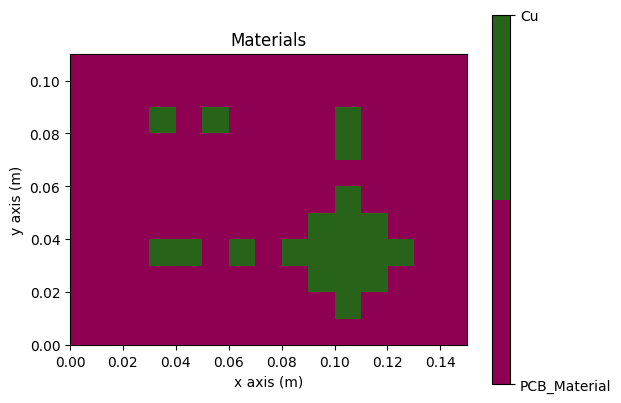

['PCB_Material', 'Cu']


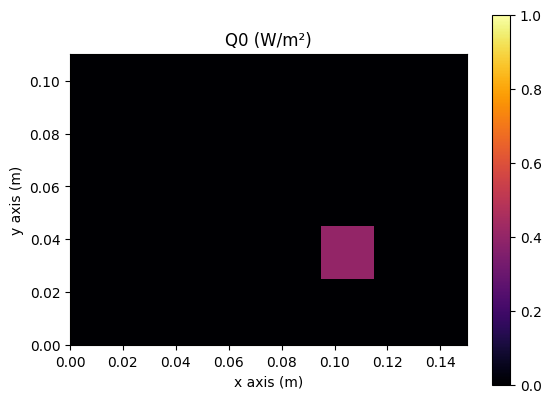

In [217]:
# Check simulation set-up
Project_Example.show_figure(figure_type = 'materials')
Project_Example.show_figure(figure_type = 'Q0')

## Running the Simulation

With the materials and power dissipations set up, we run the heatrapy command to run the simulation. 

In this particular case, we are running the simulation for 120 seconds (or 2 min) and recording data every 1 second. 

In this case, heatrapy is running a transient analysis with each of the components running at their specified powers at a constant rate while under the specified boundary conditions - which were the insulated sides.

Finished simulation


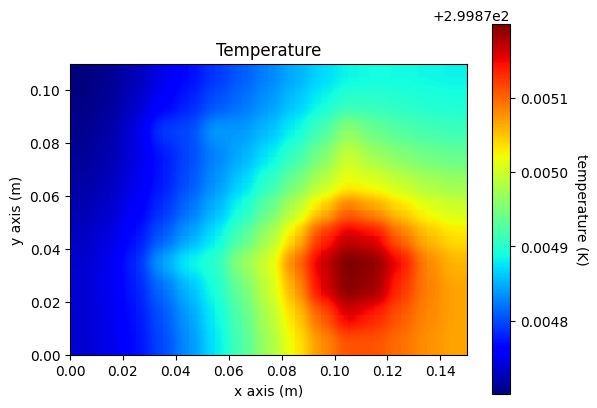

In [218]:
Project_Example.compute(1200, 10, solver='explicit_general')
Project_Example.show_figure('temperature')

Once the simulation is complete, a temperature plot of the PCB board is generated - which will then lead to us calculating the temperature margins of each component. This will then tell us how effective the heatsinks were in cooling the components while active. Note that the colorbar values are meant to be added to the top temperature number (i.e. 1e-6+3.0000032e2 = 300 K).

# Accuracy

A simple thermal analysis was ran on Solidworks to compare the accuracy of heatrapy's results. In order to establish a baseline, a thermal analysis WITHOUT any effects from the heatsinks was made. With this, the accuracy of the model and thermal equations of heatrapy can be validated. 
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/FEA%20-%203D%20Model.png" width="800"/>
<br>
<br>
A simplified PCB board that does not include the mounting holes was made. Control Surfaces were placed on the simplified PCB board to simulate the PCB lead pads that were put in heatrapy's model. 
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/FEA%20-%20Solder%20PAds.PNG" width="800"/>
<br>
<br>
The thermal properties of the PCB were then input into the PCB material in Solidworks. It was found out in the PCB section of this notebook that the thermal conductivities in the transverse direction was 143.208 W/mK and 27.5817 W/mK in the normal direction (NOTE: the y-direction is the normal direction in the Solidworks model and in the z-direction in heatrapy). The values of the densities and specific heat were also input into the PCB materials list. The PCB electrical lead pads were treated as Cold-Rolled Copper, which has similar properties to those in the heatrapy standard material library. Then finally, an initial temperature of 300 K was imposed in the Solidworks model - the same condition as was set in heatrapy. 
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/FEA%20-%20Parameters.PNG" width="800"/>
<br>
<br>
With the control surfaces set up in the Solidworks model, the same heat fluxes were put into the same locations as they were in the heatrapy model. One interesting thing to note is that the Solidworks model has a more robust and distinct contour than in the heatrapy model. This is mainly because of the scaling of the heatrapy heat flux plot. Unfortunately, there was no input argument to fix the scaling of the heat flux plot in heatrapy, but the fact that that we can see a slight gradient on the edges of the control surfaces matches with the gradient shape we see in the Solidworks model. 
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/FEA%20-%20Heat%20Dissipation.PNG" width="800"/>
<br>
<br>
Finally, a somewhat fine mesh was put over the Solidworks model. In this case - because of all the simplifications we did on the Solidworks model - we can put a fine mesh as shown below. However, the more complex the lead shapes are and the more components that need to be modeled there are, the mesh quality can get out of hand. This is what gives the heatrapy modelling an advantage since it is more forgiving on the meshing to an extent.
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/FEA%20-%20Mesh.PNG" width="600"/>
<br>
<br>
The Solidworks simulation was then ran as a transient thermal analysis for two minutes. The thermal plot of the board after the 2 minutes is shown below.
<br>
<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/FEA%20-%20Temp%20Gradient.PNG" width="800"/>
<br>
<br>
At a glance, we can see that the contour plots look very similar to each other. Again, the Solidworks simulation has a more robust gradient than the heatrapy model - but this is due to heatrapy having no argument on the scaling for the temperature plot. Regardless, the hot spot zones are in the appropriate places, and - most importantly - the gradient looks very similar. If you take the shape of the green color in the Solidworks plot, it looks very similar to the sky blue color in the heatrapy model. This gives the heatrapy model a good level of confidence to be used for quick thermal analyses. 

# Results

No Cooling Effects
<br>
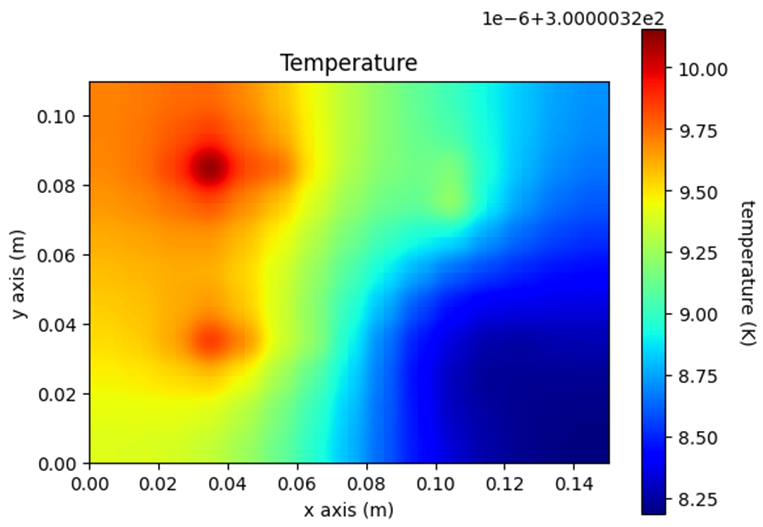
<br>
<br>
Cooling Effects (Heat Sink with 16 Fins)
<br>
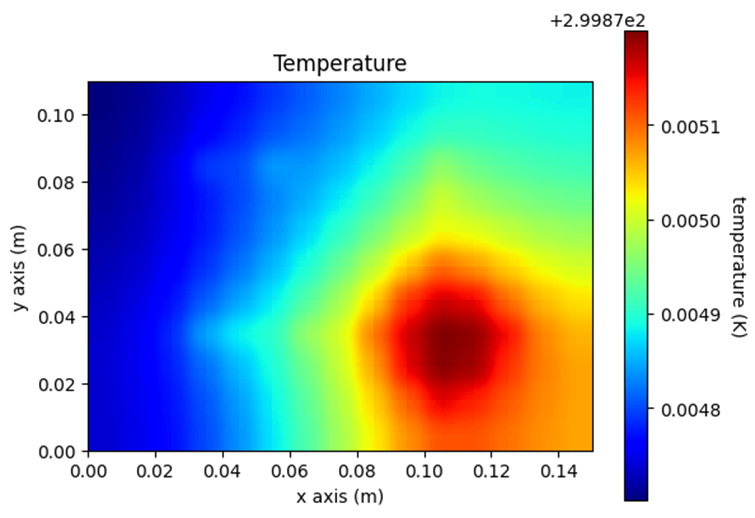
<br>
<br>
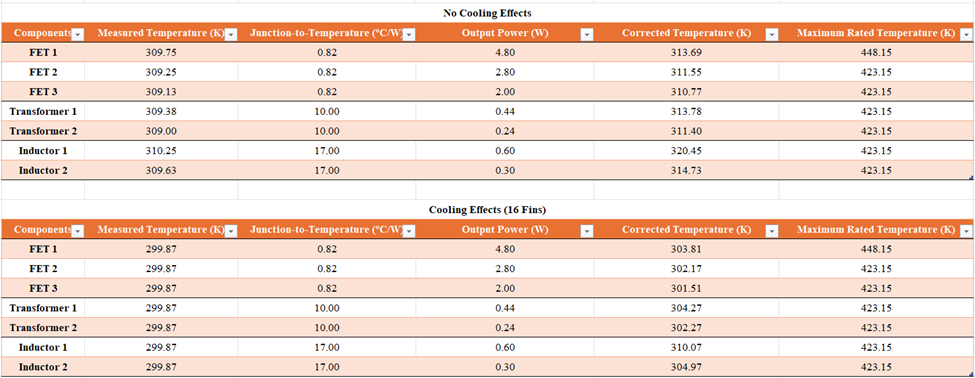

# Conclusions

The PCB board’s experienced temperatures, as read from heatrapy’s plots, ranged from 308 to 310.25 Kelvin without the cooling effect of the heat sink and without the junction-to-temperature, which accounts for the higher temperature of the element inside the case of each component. This junction-to-temperature raises the inductor 1’s temperature to 320.45 Kelvin. All of the components are well within their operating ranges and their maximum rated temperatures. After applying the cooling effects of a 16-fin aluminum heat sink, the maximum temperatures, as read from heatrapy’s plots, decreased by 6.4 percent as the temperature is consistently 299.87 Kelvin across the PCB board. The heat sink helped distribute the temperature across the board as seen in the temperature plot for the heat sink simulation in the Results section. The inductor 1’s temperature after the junction-to-temperature correction is 310.07 Kelvin, which is 3.2 percent less than the component’s corrected temperature without cooling effects.

# Improvements

## Dimension Resolution

The default resolution for the positional steps is .01 m (or cm) in the heatrapy module. Typical PCB lead sizes and locations are given in mm in their datasheets due to how small and compact their casings are. Increasing the resolution of the thermal simulation to mm often resulted in run-time errors in our experience, so this example was conducted with the default cm instead. However, this leads to other inaccuracies that could impact the results of the thermal analysis - such as over-exaggerated PCB lead pad locations that affect thermal spreading and heat flux inputs. While this script may be ideal for larger PCBs with large component leads and distinct spacing that works with a cm resolution, modelling and simulating smaller PCB boards with common COTS components leads might not be the most reliable because of this. One way to improve this code would be to try to address the run-time errors from the increased resolution of the dimenionsal steps. 

## Additional Materials

One drawback to this script is that there was not a very clean way of adding additional materials to the heatrapy material library indefinitely. Currently, the Material_Creation() class methods only alter one material in the material database, the 'PCB_Material' file that was created manually first (and altered in this script). At the time of making this code, we could not find a way to make new materials in the database with all the required text files and values inside of them, so one area of improvement would be to make a new script that makes additional materials. This would be useful since the component leads and pads are not always made of Copper. Furthermore, the heat sink function uses a different material database. Combining these libraries together will reduce file size and it would be more convenient to have all of the materials defined in one class.

## 3D Simulation

The next level of complexity for this would be for a 3D system that takes into account the normal direction, as well. The Overall() class methods do have a function to calculate the thermal conductivity in the normal direction, but there is no current way to integrate that into the system due to the class methods of the heatrapy module. Heatrapy, at the moment, can only model 1D and 2D simulations, so unless the developer makes a new update to integrate a 3D simulation, this will have to either be done using another library, or by ourselves. Developing a code for this ourselves is possible by setting up a system of equations for energy balances in all 3 directions - but was not done in this project due to time limitations. And this would be helpful since seeing the temperature distribution across the heatsink would give a better idea on how to properly space and position components on the PCB board side. Additionally, having a 3D approach also means that we can integrate an additional type of heatsink into the analysis: spot-padding of thermal gap pads in specific locations.

## Temperature Probes

Adding the capability to probe the temperature and heat flux graphs will make data analysis much easier. Another alternative parallel to this one is fixing the temperature's scaling in the plots. They are not easily readable and would likely cause confusion/incorrect data interpretation. Adding in the junction-to-temperature to the plots will reduce post processing time. These values can be added in the PCB components class.